In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pptoolbox.platform import preprocess, WAVELENGTHS_3NM_V1
from pptoolbox.platform.automl_v4 import AutoML_v4
from pptoolbox.platform.automl_v4.utils import cross_group_predict
from pptoolbox.platform.automl_v4.loss_functions import *
from pptoolbox.platform.automl_v4.stop_functions import stopping_criteria

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, f1_score

# from skmultilearn.model_selection import iterative_train_test_split

import warnings
warnings.simplefilter("ignore")

import pickle as pkl
from pathlib import Path

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
# MLFLOW_TRACKING_URI = "http://127.0.0.1:8080" # "sqlite:///mlflow.db"

# import data

In [2]:
datasets = {
    'full': {},
    '750_950': {},
}

pulldate = "250319"

In [3]:
datafolder_path = Path ("../data/processed")

# lots should be cleaned and preprocessed

cleaned_label = pd.read_csv(datafolder_path / f"cleaned_label.csv", index_col=0)
cleaned_label['scan_month'] = pd.to_datetime(cleaned_label['scan_date'], unit='s')
cleaned_label['scan_month'] = cleaned_label['scan_month'].dt.to_period('M')

for dataset in datasets:

    cleaned_input = pd.read_csv(datafolder_path / f"cleaned_input.csv", index_col=0)

    if dataset == '750_950':
        wavelengths = cleaned_input.columns.astype(float)
        feature_mask = (wavelengths >= 750 ) & (wavelengths <= 950)
        cleaned_input = cleaned_input.loc[:, feature_mask]

    datasets[dataset]['cleaned_input'] = cleaned_input

    print(f"Dataset: {dataset} has {cleaned_input.shape} spectra and {cleaned_label.shape} label")

Dataset: full has (253, 191) spectra and (253, 6) label
Dataset: 750_950 has (253, 67) spectra and (253, 6) label


In [4]:
cleaned_label

,within_spec,era,ing_diff,Lot_Name,scan_date,scan_month
lot_id,,,,,,
65987,no,old WR,0.1765,P-P49,1709816175,2024-03
65987,no,old WR,0.1765,P-P49,1709816438,2024-03
65987,no,old WR,0.1765,P-P49,1709816890,2024-03
65987,no,old WR,0.1765,P-P49,1709817276,2024-03
65988,no,old WR,0.1949,P-P50,1709819487,2024-03
...,...,...,...,...,...,...
93796,yes,new WR,0.1143,P-P112,1741869172,2025-03
93797,no,new WR,0.1854,P-P113,1741869611,2025-03
93797,no,new WR,0.1854,P-P113,1741869965,2025-03


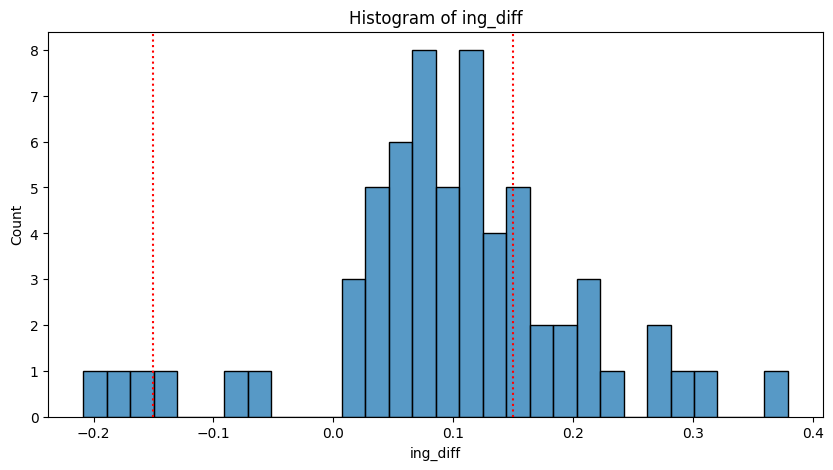

In [33]:
# plot histogram of ing_diff
plt.figure(figsize=(10, 5))
sns.histplot(cleaned_label['ing_diff'].drop_duplicates(), bins=30)
plt.title("Histogram of ing_diff")

# add red dotted lines at -0.15 and 0.15
plt.axvline(-0.15, color='red', linestyle='dotted')
plt.axvline(0.15, color='red', linestyle='dotted')

plt.show()

In [30]:
# Define fixed "OK" range
low_range = (-np.inf, -0.15)
ok_range = (-0.15, 0.15)
slightlyhigh_range = (0.15, 0.18)
high_range = (0.18, 0.25)
veryhigh_range = (0.25, np.inf)

bins = [low_range[0], low_range[1], ok_range[1], slightlyhigh_range[1], high_range[1], veryhigh_range[1]]

# Define labels
labels = ['Low', 'OK', 'Slightly High', 'High', 'Very High']

# Assign bins
cleaned_label['ing_diff_category'] = pd.cut(cleaned_label['ing_diff'], bins=bins, labels=labels, include_lowest=True)

cleaned_label

,within_spec,era,ing_diff,Lot_Name,scan_date,scan_month,ing_diff_category
lot_id,,,,,,,
65987,no,old WR,0.1765,P-P49,1709816175,2024-03,Slightly High
65987,no,old WR,0.1765,P-P49,1709816438,2024-03,Slightly High
65987,no,old WR,0.1765,P-P49,1709816890,2024-03,Slightly High
65987,no,old WR,0.1765,P-P49,1709817276,2024-03,Slightly High
65988,no,old WR,0.1949,P-P50,1709819487,2024-03,High
...,...,...,...,...,...,...,...
93796,yes,new WR,0.1143,P-P112,1741869172,2025-03,OK
93797,no,new WR,0.1854,P-P113,1741869611,2025-03,High
93797,no,new WR,0.1854,P-P113,1741869965,2025-03,High


In [31]:
cleaned_label['ing_diff_category'].value_counts()

OK               165
Slightly High     28
High              28
Very High         20
Low               12
Name: ing_diff_category, dtype: int64

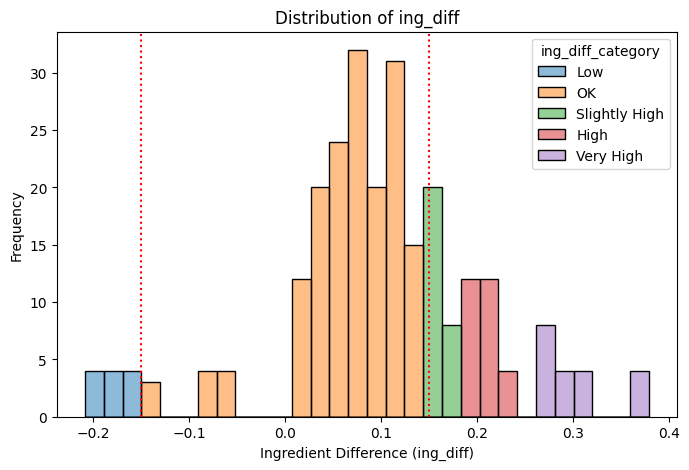

In [34]:
plt.figure(figsize=(8, 5))
sns.histplot(data=cleaned_label, x="ing_diff", hue="ing_diff_category", bins=30)

# Labels and title
plt.xlabel("Ingredient Difference (ing_diff)")
plt.ylabel("Frequency")
plt.title("Distribution of ing_diff")

# add red dotted lines at -0.15 and 0.15
plt.axvline(-0.15, color='red', linestyle='dotted')
plt.axvline(0.15, color='red', linestyle='dotted')
plt.show()

# train test split random

In [ ]:
# # random split
# def train_test_split_lot_level (label_df, test_size=0.1):
#     label = label_df.set_index('lot_id')
#     sorted_idx = label.index.unique()
#     train_label, test_label = train_test_split(label.loc[sorted_idx], 
#                                                  test_size=test_size, 
#                                                  stratify=label.loc[sorted_idx]['ABOVE_BELOW_5pct_Dwarf'],
#                                                  shuffle=True, 
#                                                  random_state=42)
    
#     train_idx = train_label.index.sort_values()
#     test_idx = test_label.index.sort_values()

#     return train_idx, test_idx

# train_index, test_index = train_test_split_lot_level(label_df)
# print(train_index, test_index)

# #is test_idx in train_idx
# print(f'Is test index subset of train index? {set(test_index).issubset(set(train_index))}')


# split by time

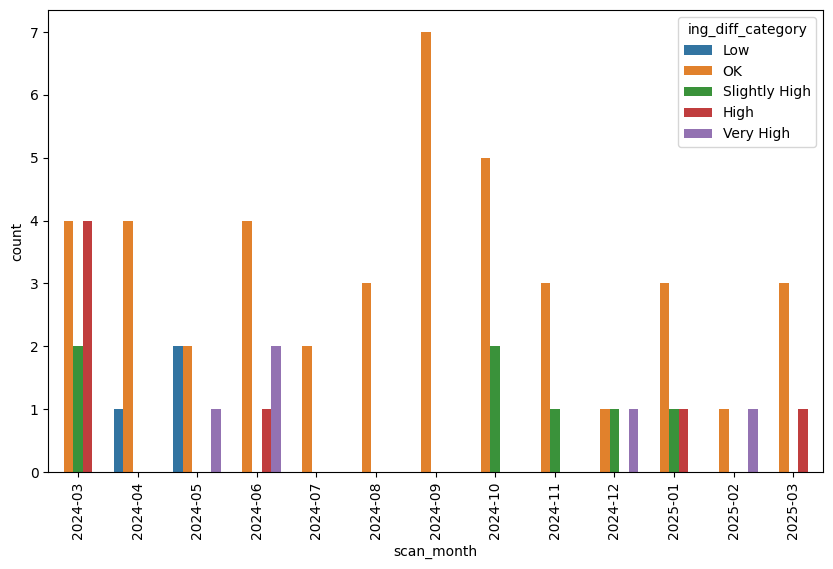

In [38]:
# plot distribution of date_scanned coloured by param

label_df = cleaned_label.copy()
label_df = label_df[~label_df.index.duplicated(keep='first')]

fig = plt.figure(figsize=(10, 6))
sns.countplot(
    data=label_df, 
    x='scan_month', 
    hue='ing_diff_category', 
    # hue_order=['yes', 'no']
    )
plt.xticks(rotation=90)

fig.show()

In [50]:
# i want to set the last 20 % of the data as test set, stratified by Rancidity (Class-text)

# Function to split last 20% as test set for each category
def split_last_20_percent(group):
    test_size = int(len(group) * 0.2)  # 20% of the group

    # ensure that test set has at least 1 sample from each category
    if test_size == 0:
        test_size = 1

    test_set = group.iloc[-test_size:]  # Last 20% as test set
    train_set = group.iloc[:-test_size]  # Remaining 80% as train set
    train_idx = train_set.index
    test_idx = test_set.index
    return train_idx, test_idx

# Apply function to each Rancidity category
train_idxs, test_idxs = zip(*label_df.groupby('ing_diff_category').apply(split_last_20_percent))

# Combine train and test indices
train_idx = np.concatenate(train_idxs)
test_idx = np.concatenate(test_idxs)

# Check if train and test indices are disjoint
print(f'train and test is disjoint: {set(train_idx).isdisjoint(set(test_idx))}')

# print shape of train and test indices
print(train_idx.shape, test_idx.shape)

train and test is disjoint: True
(52,) (12,)


In [65]:
for dataset in datasets:
    print(f'\nProcessing {dataset} dataset')
    save_dir = f"../data/processed/timesplit/{dataset}"
    Path(save_dir).mkdir(parents=True, exist_ok=True)

    cleaned_input = datasets[dataset]['cleaned_input']
    print(f'cleaned_input: {cleaned_input.shape}, cleaned_label: {cleaned_label.shape}')

    # train_idx = datasets[dataset]['train_idx']
    # test_idx = datasets[dataset]['test_idx']
    print(f'cleaned_label: {cleaned_label.reset_index().drop_duplicates().shape}, train_idx: {train_idx.shape}, test_idx: {test_idx.shape}')

    X_train = cleaned_input[cleaned_input.index.isin(train_idx)]
    X_test = cleaned_input[cleaned_input.index.isin(test_idx)]
    y_train = cleaned_label[cleaned_label.index.isin(train_idx)]
    y_test = cleaned_label[cleaned_label.index.isin(test_idx)]

    print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
    print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

    X_train.to_csv(f'{save_dir}/Xtrain.csv')
    X_test.to_csv(f'{save_dir}/Xtest.csv')
    y_train.to_csv(f'{save_dir}/ytrain.csv')
    y_test.to_csv(f'{save_dir}/ytest.csv')

    datasets[dataset]['X_train'] = X_train
    datasets[dataset]['X_test'] = X_test
    datasets[dataset]['y_train'] = y_train
    datasets[dataset]['y_test'] = y_test


Processing full dataset
cleaned_input: (253, 191), cleaned_label: (253, 7)
cleaned_label: (253, 8), train_idx: (52,), test_idx: (12,)
X_train: (205, 191), y_train: (205, 7)
X_test: (48, 191), y_test: (48, 7)

Processing 750_950 dataset
cleaned_input: (253, 67), cleaned_label: (253, 7)
cleaned_label: (253, 8), train_idx: (52,), test_idx: (12,)
X_train: (205, 67), y_train: (205, 7)
X_test: (48, 67), y_test: (48, 7)


In [66]:
y_train.drop_duplicates('Lot_Name').value_counts('ing_diff_category')

ing_diff_category
OK               34
Slightly High     6
High              6
Very High         4
Low               2
dtype: int64

In [67]:
y_test.drop_duplicates('Lot_Name').value_counts('ing_diff_category')

ing_diff_category
OK               8
Low              1
Slightly High    1
High             1
Very High        1
dtype: int64